# Part IV: Sentiment analysis using LSTM [20 points]
In this part, we perform a sentiment analysis using LSTM model. The final (improved) model should achieve a test accuracy of greater than 75%.

In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import time
from torch import torch, nn, optim
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from torchinfo import summary
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import spacy
spacy_model = spacy.load('en_core_web_sm')
import re 
import string
from pprint import pprint


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/harshit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
torch.manual_seed(42)
random.seed(42)
torch.mps.manual_seed(42)

## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the main statistics

In [ ]:
### ADD YOUR CODE HERE ###
path_to_dataset = 'dataset/Tweets.csv'

df = pd.read_csv(path_to_dataset)

In [58]:
df.shape

(14640, 15)

2. Print the first 5 rows of the dataset to understand its structure

In [6]:
### ADD YOUR CODE HERE ###

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


3. Provide a brief description of the dataset

Link: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

This dataset is of top US Airline reviews from Twitter. This dataset was scraped from February 2015 and classified into 3 sentiments: Positive, Negative, and Neutral tweets. 

4. Display descriptive statistics

In [7]:

num_samples = df.shape[0]

print(f"Number of samples: {num_samples}") # Number of Samples'
print(f"Sentiments: {df['airline_sentiment'].unique()}") # Unique sentiments



Number of samples: 14640
Sentiments: ['neutral' 'positive' 'negative']


In [8]:
# Print class distribution
for item in df['airline_sentiment'].unique():
    count = (df['airline_sentiment'] == item).sum()
    percentage = (count / num_samples) * 100
    print(f"{item} \t {count} \t {percentage:.2f}%")

neutral 	 3099 	 21.17%
positive 	 2363 	 16.14%
negative 	 9178 	 62.69%


In [9]:
# Average review length
count_letters = 0
count_words = 0
for item in df['text']:
    count_letters += len(item)
    count_words += len(item.split())

print(f"Average word length = {count_words/num_samples:.2f}")
print(f"Average characater length = {count_letters/num_samples:.2f}")

Average word length = 17.65
Average characater length = 103.82


In [10]:
# Get Vocabulary info

my_vocab = {}
for item in df['text']:
    words = item.lower().split()
    for word in words:
        word = word.translate(str.maketrans('', '', string.punctuation))
        # Exclude words that:
        # 1. Start with '@' (mentions)
        # 2. Contain numbers (pure numbers or mixed)
        # 3. Look like dates (e.g., "2/22")
        # 4. Are links (starting with 'http')
        # 5. Contain '#' (hashtags)
        if not re.match(r"^@|http|\d|#", word):
            my_vocab[word] = my_vocab.get(word, 0) + 1

my_vocab_sorted = sorted(my_vocab.items(), key=lambda item: item[1], reverse=True)
print(my_vocab_sorted)

[('to', 8640), ('the', 6050), ('i', 5372), ('a', 4476), ('united', 4117), ('you', 4105), ('for', 3991), ('flight', 3870), ('on', 3778), ('and', 3709), ('my', 3273), ('usairways', 3039), ('americanair', 2938), ('is', 2827), ('in', 2527), ('southwestair', 2441), ('jetblue', 2256), ('of', 2119), ('me', 1910), ('it', 1877), ('', 1824), ('your', 1738), ('have', 1642), ('was', 1606), ('not', 1563), ('with', 1523), ('that', 1497), ('at', 1483), ('no', 1469), ('this', 1383), ('get', 1334), ('but', 1227), ('be', 1202), ('from', 1198), ('can', 1108), ('are', 1096), ('thanks', 1071), ('cancelled', 1056), ('we', 1046), ('now', 1021), ('an', 983), ('just', 964), ('service', 953), ('do', 917), ('so', 890), ('been', 866), ('help', 852), ('time', 769), ('will', 762), ('customer', 746), ('im', 740), ('up', 731), ('out', 704), ('our', 692), ('they', 689), ('us', 678), ('hours', 669), ('what', 662), ('when', 648), ('flights', 645), ('amp', 637), ('hold', 637), ('how', 635), ('if', 621), ('plane', 617), (

In [316]:

print(f"Lenght of Vocabulary = {len(my_vocab_sorted)}")# Length of my vocabulary
print(f"Top 5 words: {my_vocab_sorted[:5]}")


Lenght of Vocabulary = 14194
Top 5 words: [('to', 8640), ('the', 6050), ('i', 5372), ('a', 4476), ('united', 4117)]


5. Handle missing values

In [317]:
### ADD YOUR CODE HERE ###
print(f"Missing values in Tweet column: {df['text'].isna().sum()}")
print(f"Missing values in Sentiment column: {df['airline_sentiment'].isna().sum()}")


Missing values in Tweet column: 0
Missing values in Sentiment column: 0


There is no missing valus, so no need to do anything.

6. Create visualizations to gain insights into the data

In [318]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

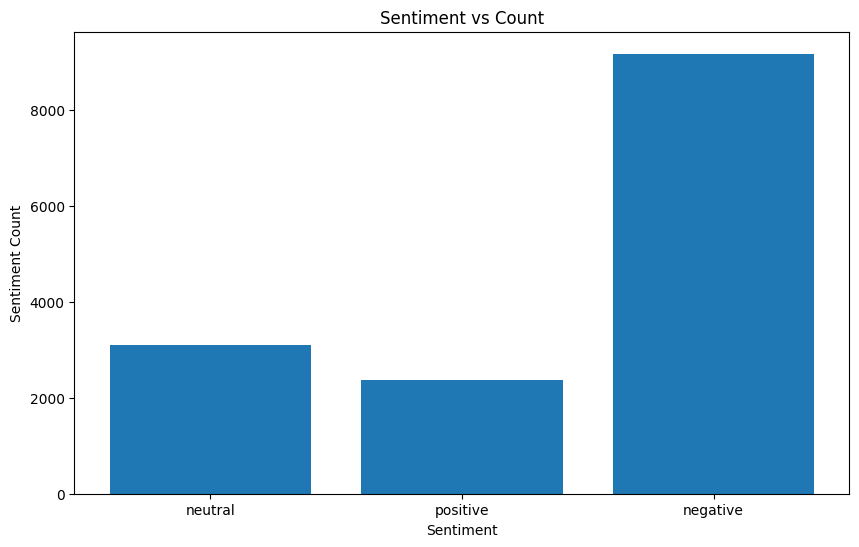

In [319]:


# Plot 1: Sentiment counts

sentiments = df['airline_sentiment'].unique()
count_sentiments = [(df['airline_sentiment'] == item).sum() for item in sentiments]

plt.figure(figsize=(10, 6))
plt.bar(sentiments, count_sentiments)
plt.title("Sentiment vs Count")
plt.xlabel("Sentiment")
plt.ylabel("Sentiment Count")
plt.show()

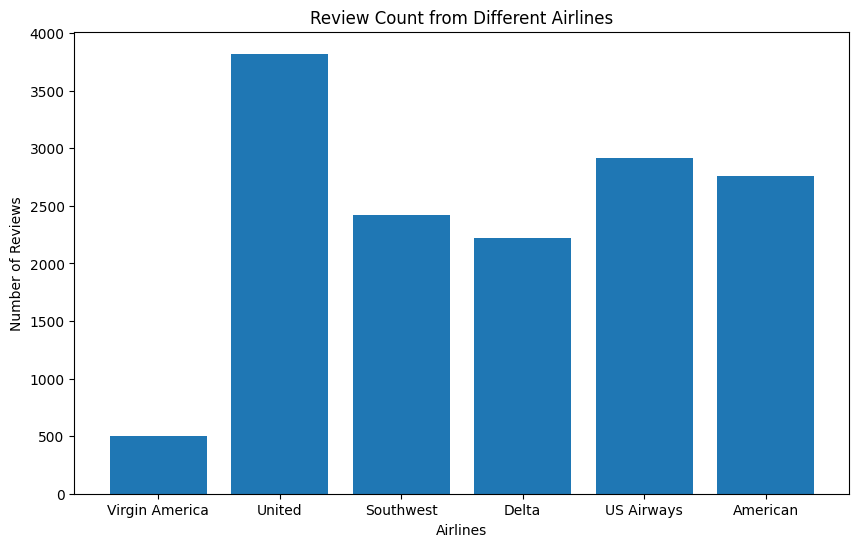

In [320]:
# Plor 2: Reviws from different airlines

airlines = df['airline'].unique()
count_airlines = [(df['airline'] == item).sum() for item in airlines]

plt.figure(figsize=(10, 6))
plt.bar(airlines, count_airlines)
plt.title("Review Count from Different Airlines")
plt.xlabel("Airlines")
plt.ylabel("Number of Reviews")
plt.show()

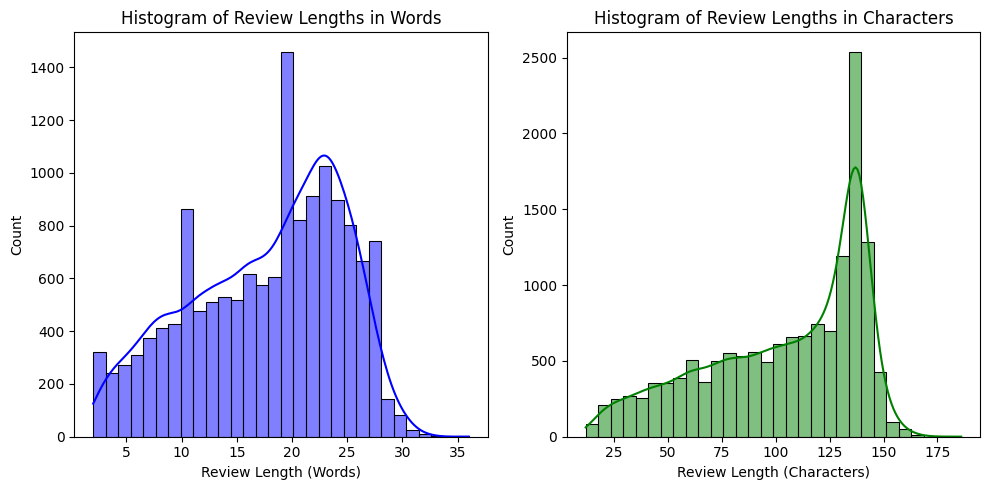

In [321]:
# Plot 3: Review length plots

df['length_words'] = df['text'].apply(lambda x: len(x.split()))
df['length_chars'] = df['text'].apply(len)

plt.figure(figsize=(10, 5))

# Plot histogram for words
plt.subplot(1, 2, 1)
sns.histplot(df['length_words'], bins=30, kde=True, color='blue')
plt.xlabel("Review Length (Words)")
plt.ylabel("Count")
plt.title("Histogram of Review Lengths in Words")

# Plot histogram for characters
plt.subplot(1, 2, 2)
sns.histplot(df['length_chars'], bins=30, kde=True, color='green')
plt.xlabel("Review Length (Characters)")
plt.ylabel("Count")
plt.title("Histogram of Review Lengths in Characters")

plt.tight_layout()
plt.show()


Plot: Word Cloud for neutral


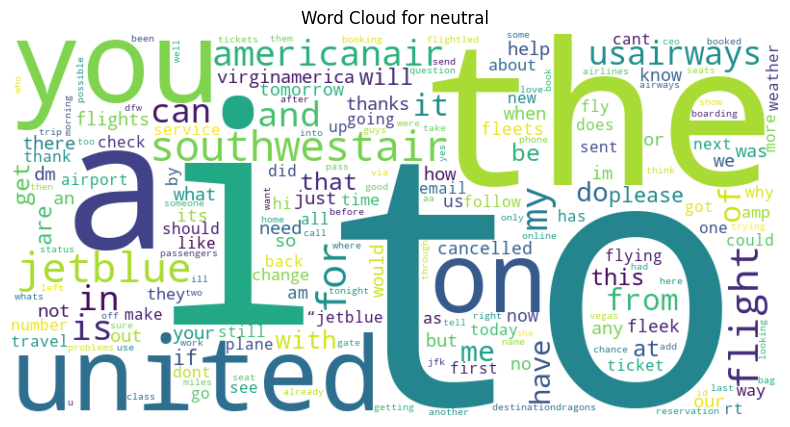

Plot: Word Cloud for positive


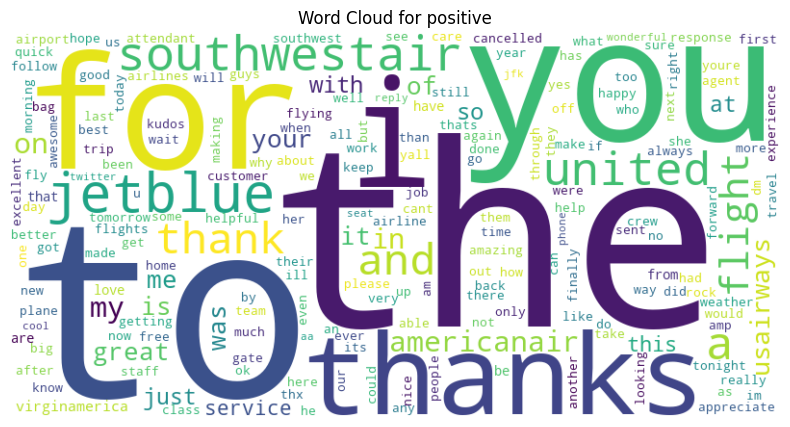

Plot: Word Cloud for negative


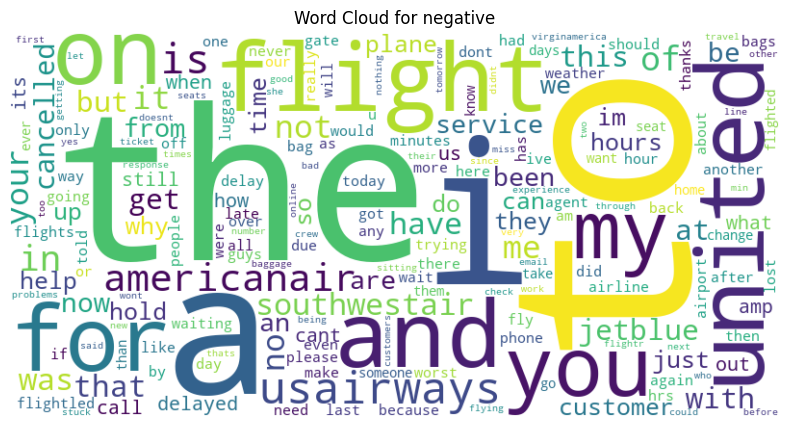

In [322]:
# Plot 4: Word Cloud

def plot_wordcloud(vocab, sentiment):
    print(f"Plot: Word Cloud for {sentiment}")
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment}")
    plt.show()


sent_vocab = {}
for item in sentiments:
    sent_vocab[item] = {}

for _, item in df.iterrows():
    sentiment = item['airline_sentiment']
    tweet = item['text']

    words = tweet.translate(str.maketrans('', '', string.punctuation)).lower().split() # Dict of words

    for word in words:
        if not re.match(r"^@|http|\d|#", word):
            if word in sent_vocab[sentiment]:
                sent_vocab[sentiment][word] += 1
            else:
                sent_vocab[sentiment][word] = 1

for item in sent_vocab.keys():
    plot_wordcloud(sent_vocab[item], item)


7. Data preparation

Here I am using NTLK toolkit and Spacy library for data preparation and tokenization. These are the two most famous for natural language processing in python. 

In [323]:
# Playing around with NLTK and Spacy

text = "Apple is looking at buying U.K. startup for $1 billion" # Example text
doc = spacy_model(text)

tokens_nltk = word_tokenize(text)
tokens_spacy = []

for token in doc:
    tokens_spacy.append(token.text)

print("NLTK: ", tokens_nltk)
print("Spacy: ", tokens_spacy)



NLTK:  ['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '$', '1', 'billion']
Spacy:  ['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '$', '1', 'billion']


In [12]:
# Create a new dataframe containing only two columns: tweet and sentiment

df_new = df[['text', 'airline_sentiment']].copy()
df_new.columns = ['tweet', 'sentiment']

df_new.head()


,tweet,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [13]:
# Creating vocabulary using NLTK
vocab_nltk = {}
for words in df_new['tweet']:
    words = words.translate(str.maketrans('', '', string.punctuation)).lower() # Remove Punctuations and convert to lower case
    tokens = word_tokenize(words)
    
    for word in tokens:
        if not re.match(r"^@|http|\d|#", word):
            vocab_nltk[word] = vocab_nltk.get(word, 0) + 1

print("Length of vocab using NLTK Tokenizer: ", len(vocab_nltk))

Length of vocab using NLTK Tokenizer:  14095


In [14]:
vocab_spacy = {}
for words in df_new['tweet']:
    words = words.translate(str.maketrans('', '', string.punctuation)).lower() # Remove Punctuations and convert to lower case
    
    doc = spacy_model(words)
    tokens_spacy = []

    for token in doc:
        tokens_spacy.append(token.text)
    
    for word in tokens_spacy:
        if not re.match(r"^@|http|\d|#", word):
            vocab_spacy[word] = vocab_spacy.get(word, 0) + 1

print("Length of vocab using Spacy Tokenizer: ", len(vocab_spacy))

Length of vocab using Spacy Tokenizer:  13860


In [16]:
type(doc)

spacy.tokens.doc.Doc

In [17]:
# Print top vocabulary items

print(sorted(vocab_nltk.items(), key=lambda item: item[1], reverse=True))
print(sorted(vocab_spacy.items(), key=lambda item: item[1], reverse=True))

[('to', 8641), ('the', 6050), ('i', 5413), ('a', 4476), ('united', 4142), ('you', 4112), ('for', 3991), ('flight', 3872), ('on', 3778), ('and', 3709), ('my', 3273), ('usairways', 3051), ('americanair', 2957), ('is', 2827), ('in', 2527), ('southwestair', 2453), ('jetblue', 2364), ('of', 2119), ('me', 1913), ('it', 1893), ('your', 1738), ('have', 1642), ('not', 1614), ('was', 1606), ('with', 1523), ('that', 1498), ('at', 1483), ('no', 1470), ('this', 1384), ('get', 1334), ('but', 1227), ('be', 1203), ('from', 1198), ('can', 1165), ('are', 1096), ('thanks', 1071), ('we', 1061), ('cancelled', 1056), ('now', 1022), ('an', 983), ('just', 964), ('service', 953), ('do', 917), ('so', 890), ('been', 866), ('help', 853), ('time', 769), ('will', 762), ('customer', 747), ('im', 740), ('up', 731), ('out', 704), ('our', 692), ('they', 690), ('us', 679), ('hours', 669), ('what', 665), ('when', 648), ('flights', 645), ('amp', 637), ('hold', 637), ('how', 635), ('if', 621), ('plane', 617), ('all', 616),

It is observed that NLTK takes way less time to build vocabulary as compared to Spacy. This is because Spacy uses pre-trained models for tokenization. Spacy returns a Doc object, which containes within it sentences and tokens. We can iterate through tokens with a for loop. Spacy also can be used for parts of speech tagging and lemmatization (converting a word into its base word). Since, spacy does a lot of things in the backend so it takes more time for tokenization and building vocabulary.

Also, spacy does a better job in tokenization. For example, after removing punctuation from the word "doesn't" and passing it through both tokenizer function, nltk is not able to tokenize it into 'does' and 'nt', but spacy is able to find that this word is a mixture of two words or tokens. This is demonstrated below:

In [329]:
print("Using NLTK: ", word_tokenize("doesnt"))
tokensss = []
for token in spacy_model("doesnt"):
    tokensss.append(token)
print("Using Spacy: ", tokensss)

Using NLTK:  ['doesnt']
Using Spacy:  [does, nt]


In [330]:
'doesnt' in vocab_spacy

False

In [331]:
print(vocab_spacy['does'], vocab_spacy['nt'])
print(vocab_nltk['does'], vocab_nltk['nt'], vocab_nltk["doesnt"])

364 2211
185 2 174


Here the count of the token 'does' and 'nt' is higher in Spacy vocab because it is able to tokenize it into two different words, and NLTK cannot do that.

8. Split dataset into train, validation, and test sets

In [18]:
df_new.head()

,tweet,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [19]:
# Convert tweets into tokens

def clean_data(x): # Function to clean text
    # Remove emoji
    x = re.sub(r'\s*([\U00010000-\U0010ffff])\s*', '', x)

    # Remove hyperlink
    x = re.sub(r'http\S+|www\.\S+', '', x)

    # Remove @ Mentions
    x = re.sub(r'@\w+', '', x)

    # Remove numbers like dates
    x = re.sub(r'\d+', '', x)

    # Remove Hashtags
    x = re.sub(r'#(\w+)', r'\1', x)

    # Remove punctuations
    x = x.translate(str.maketrans('', '', string.punctuation))

    # Convert to lower case
    x = x.lower()

    return x

def remove_stopwords(tokens): # Function to remove stopwords from tokens
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

df_new["text_seq"] = None

for idx in range(df_new.shape[0]):
    item = df_new.loc[idx, 'tweet']
    tokens = word_tokenize(clean_data(item))
    tokens = remove_stopwords(tokens) # Remove Stopwords

    if len(tokens) > 0:
        df_new.at[idx, "text_seq"] = tokens
    else:
        df_new.drop(idx, inplace=True)

df_new = df_new.reset_index(drop=True)

In [20]:
df_new

,tweet,sentiment,text_seq
0,@VirginAmerica What @dhepburn said.,neutral,[said]
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, youve, added, commercials, experience, ..."
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[didnt, today, must, mean, need, take, another..."
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta..."
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]"
...,...,...,...
14613,@AmericanAir thank you we got on a different f...,positive,"[thank, got, different, flight, chicago]"
14614,@AmericanAir leaving over 20 minutes Late Flig...,negative,"[leaving, minutes, late, flight, warnings, com..."
14615,@AmericanAir Please bring American Airlines to...,neutral,"[please, bring, american, airlines, blackberry]"
14616,"@AmericanAir you have my money, you change my ...",negative,"[money, change, flight, dont, answer, phones, ..."


In [ ]:
# Split data into training set for vocab creation

X = df_new.drop(columns=['sentiment', 'tweet'])
Y = df_new['sentiment']

# Split into 70:15:15 ratio of Train:Validate:Test
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)


In [357]:
X_train 

,text_seq
3006,"[based, suggestions, passengers, rental, car, ..."
9209,"[expedia, reserved, ticket, usaw, flight, issu..."
2781,"[million, mile, flier, im, embarrassed, ask, l..."
9311,"[receipt, conf, thur, flight, call, help, lite..."
8639,"[thats, said, last, night, though]"
...,...
5191,"[flight, four, hours, plane, ground, bwi]"
13418,"[hear, delta, offering, miles, frequent, flyer..."
5390,"[glad, u, guys, business, w, class, ur, compet..."
860,"[ua, pacific, rim, date, night, cut, constantl..."


In [22]:
# Create vocabulary of training data

training_vocab = {}
seq_len = []
i = 1

for idx in X_train.index: 
    item = X_train.at[idx, 'text_seq']
    seq_len.append(len(item))
    
    for word in item:  # Create vocabulary and map words
        if word not in training_vocab:
            training_vocab[word] = i
            i += 1

print(training_vocab)
print(len(training_vocab))

{'based': 1, 'suggestions': 2, 'passengers': 3, 'rental': 4, 'car': 5, 'standby': 6, 'one': 7, 'way': 8, 'another': 9, 'leaving': 10, 'expedia': 11, 'reserved': 12, 'ticket': 13, 'usaw': 14, 'flight': 15, 'issued': 16, 'responsivethoughts': 17, 'million': 18, 'mile': 19, 'flier': 20, 'im': 21, 'embarrassed': 22, 'ask': 23, 'long': 24, 'ago': 25, 'launched': 26, 'receipt': 27, 'conf': 28, 'thur': 29, 'call': 30, 'help': 31, 'literally': 32, 'hung': 33, 'bc': 34, 'wait': 35, 'times': 36, 'thats': 37, 'said': 38, 'last': 39, 'night': 40, 'though': 41, 'rt': 42, 'nice': 43, 'delay': 44, 'second': 45, 'trip': 46, 'left': 47, 'engine': 48, 'leakingwhats': 49, 'next': 50, 'usair': 51, 'nothappy': 52, 'weve': 53, 'already': 54, 'made': 55, 'arrangements': 56, 'worst': 57, 'customer': 58, 'service': 59, 'earth': 60, 'never': 61, 'fly': 62, 'airline': 63, 'personal': 64, 'email': 65, 'contact': 66, 'complaint': 67, 'know': 68, 'landed': 69, 'might': 70, 'want': 71, 'check': 72, 'plane': 73, 'hou

In [23]:
# Create an index for Out of Vocabulary word (OOV)
training_vocab['oov'] = len(training_vocab) + 1
len(training_vocab)

10249

In [24]:
perc95 = int(np.percentile(seq_len, 95))
print("95th Percentile length = ", perc95)

95th Percentile length =  15


In [25]:
# Now convert whole dataframe to sequence
for idx in X.index: 
    item = X.at[idx, 'text_seq']
    seq = []
    for word in item:
        if word not in training_vocab:
            word = 'oov'
        seq.append(training_vocab[word])
    # Apply padding or truncation 
    if len(seq) < perc95:
        num_padding = int(perc95 - len(seq))
        seq.extend([0] * num_padding)
    elif len(seq) > perc95:
        seq = seq[:perc95] 
    X.at[idx, "text_seq"] = seq

In [26]:
X.head()

,text_seq
0,"[38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[1165, 866, 3923, 5104, 524, 8987, 0, 0, 0, 0,..."
2,"[444, 362, 374, 270, 112, 137, 9, 46, 0, 0, 0,..."
3,"[102, 5664, 7073, 4411, 491, 9411, 6642, 77, 1..."
4,"[102, 966, 548, 734, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [27]:
Y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: sentiment, dtype: object

Impact of Padding and Truncation :

Padding helps to make training data of uniform lenghts. This ensures that the shorter sequences are extended to a uniform size without destroying their original structure.

There are very few tweets (roughly 5%) which are very long. Having too much input sequences will increase model training time. So we are truncating our sequence to 95th percentile length to make it uniform and better training.

In [28]:
# Now split into trainin, test, and validation dataset using same random state as above

# Split into 70:15:15 ratio of Train:Validate:Test
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the sizes of the datasets
print(f"X Training set size: {X_train.shape}")
print(f"X Validation set size: {X_validate.shape}")
print(f"X Testing set size: {X_test.shape}")
print(f"Y Training set size: {y_train.shape}")
print(f"Y Validation set size: {y_validate.shape}")
print(f"Y Testing set size: {y_test.shape}")

X Training set size: (10232, 1)
X Validation set size: (2193, 1)
X Testing set size: (2193, 1)
Y Training set size: (10232,)
Y Validation set size: (2193,)
Y Testing set size: (2193,)


## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [35]:
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(SentimentAnalysisLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [33]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(device)

device = torch.device("cpu")

In [ ]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.2
batch_size = 32

model = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

summary(model, input_size=(batch_size, perc95), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
SentimentAnalysisLSTM                    [32, 3]                   --
├─Embedding: 1-1                         [32, 15, 100]             1,025,000
├─LSTM: 1-2                              [32, 15, 128]             117,760
├─Dropout: 1-3                           [32, 15, 128]             --
├─LSTM: 1-4                              [32, 15, 128]             132,096
├─Dropout: 1-5                           [32, 15, 128]             --
├─LSTM: 1-6                              [32, 15, 128]             132,096
├─Dropout: 1-7                           [32, 15, 128]             --
├─Linear: 1-8                            [32, 3]                   387
├─Softmax: 1-9                           [32, 3]                   --
Total params: 1,407,339
Trainable params: 1,407,339
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 216.15
Input size (MB): 0.00
Forward/backward pass size (MB): 1.86
Params size (MB): 5.63
E

2. Train your model

In [37]:
def prepare_data(X_data, y_data, batch_size):
    
    X_tensor = torch.LongTensor(X_data['text_seq'].tolist()) # Convert ists to a PyTorch tensor

    y_tensor = torch.LongTensor(y_data.map({'neutral': 0, 'negative': 1, 'positive': 2}).to_numpy()) # Convert labels to tensor

    dataset = TensorDataset(X_tensor, y_tensor)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return data_loader

# Prepare train, validation, and test sets
train_loader = prepare_data(X_train, y_train, batch_size)
val_loader = prepare_data(X_validate, y_validate, batch_size)
test_loader = prepare_data(X_test, y_test, batch_size)

In [38]:
# Reusing code from part 1

def train_loop(dataloader, model, loss_fn, optimizer, device):
    num_batches = len(dataloader)
    model.train()
    train_loss , correct, total =0 , 0, 0

    for batch, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs) 
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    

        if batch % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{batch + 1}] loss: {train_loss / (batch+1):.3f}')
        
    # Calculate average loss and accuracy
    average_loss = train_loss / num_batches
    accuracy_train = 100 * correct / total
    
    return average_loss, accuracy_train

def validation_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            # Accumulate loss
            val_loss += loss.item()

            # Calculate number of correct predictions
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate average loss and accuracy
    average_loss = val_loss / len(dataloader)
    accuracy_val = 100 * correct / total
    
    return average_loss,accuracy_val

In [ ]:

# Reusing code from part 1

def train_model(num_epochs, model, train_loader, val_loader, loss_fn, optimizer, device):
    start_time = time.time()
    train_acc = []
    validation_acc = []
    train_loss = []
    validation_loss = []
    best_loss = float("inf")
    patience_counter = 0 
    
    for t in range(num_epochs):
        loss, acc = train_loop(train_loader, model, loss_fn, optimizer, device)
        print(f"Epoch [{t+1}/{num_epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
        v_loss, v_acc = validation_loop(val_loader, model, loss_fn, device) 
        print(f"Epoch [{t+1}/{num_epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

        if v_loss < best_loss:
            best_loss = v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs.")
        # Early stopping
        if patience_counter >= num_epochs//5:
            print(f"Early stopping! Training stopped after {t} epochs")
            break

        train_acc.append(acc)
        validation_acc.append(v_acc)
        train_loss.append(loss)
        validation_loss.append(v_loss)

        
    # Total time taken for training
    end_time = time.time()
    print(f"Training completed in: {end_time - start_time:.2f} seconds")

    print("Training accuracy is", sum(train_acc)/len(train_acc))

    print("Validation accuracy is", sum(validation_acc)/len(validation_acc))

    return train_loss, validation_loss

In [446]:
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model, train_loader, val_loader, loss_fn, optimizer, device)

Epoch [1/100], Loss: 0.956, Accuracy: 62.26%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.928, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.895, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.899, Accuracy: 63.24%
Epoch [7/100], Validation Loss: 0.872, Validation Accuracy: 66.48%
Epoch [8/100], Loss: 0.882, Accuracy: 65.64%
Epoch [8/100], Validation Loss: 0.863, Validation Accuracy: 67.12%
Epoch [9/100], Loss: 0.868, Accuracy: 66.50%
Epoch [9/100], Validation Loss: 0.855, Validation Accuracy:

<span style='color:green'>### YOUR ANSWER ###</span>

3. Evaluation and analysis

In [ ]:
# Reusing code from part 1

def test_loop(dataloader, model, loss_fn):
    model.eval()
    predictions=[]
    actual=[]
    test_loss = 0
    num_batches= len(dataloader)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            # Accumulate loss
            test_loss += loss.item()

            # Calculate number of correct predictions
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            actual.extend(labels.cpu().numpy())
            
        
    accuracy = accuracy_score(actual, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(actual, predictions, average='weighted')
    print(f"Test Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    # Average test loss over all batches
    test_loss /= num_batches
    print("Test loss is", test_loss)
    return test_loss, accuracy,actual, predictions

In [449]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model, loss_fn)

Test Accuracy: 0.7364341085271318, Precision: 0.7215328002940392, Recall: 0.7364341085271318, F1 Score: 0.7252885105024917
Test loss is 0.8142324133195739


### Training model with SGD Optimizer



In [459]:
model2 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model2, train_loader, val_loader, loss_fn, optimizer2, device)


Epoch [1/100], Loss: 1.102, Accuracy: 19.01%
Epoch [1/100], Validation Loss: 1.101, Validation Accuracy: 14.82%
Epoch [2/100], Loss: 1.101, Accuracy: 20.78%
Epoch [2/100], Validation Loss: 1.101, Validation Accuracy: 16.01%
Epoch [3/100], Loss: 1.100, Accuracy: 24.13%
Epoch [3/100], Validation Loss: 1.100, Validation Accuracy: 21.71%
Epoch [4/100], Loss: 1.100, Accuracy: 28.20%
Epoch [4/100], Validation Loss: 1.099, Validation Accuracy: 29.00%
Epoch [5/100], Loss: 1.099, Accuracy: 33.44%
Epoch [5/100], Validation Loss: 1.098, Validation Accuracy: 38.30%
Epoch [6/100], Loss: 1.098, Accuracy: 40.16%
Epoch [6/100], Validation Loss: 1.098, Validation Accuracy: 47.74%
Epoch [7/100], Loss: 1.097, Accuracy: 45.10%
Epoch [7/100], Validation Loss: 1.097, Validation Accuracy: 59.42%
Epoch [8/100], Loss: 1.097, Accuracy: 51.60%
Epoch [8/100], Validation Loss: 1.096, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 1.096, Accuracy: 55.37%
Epoch [9/100], Validation Loss: 1.095, Validation Accuracy:

Result: Accuracy is very less in the case of SGD. Adam optimizer is better. 

### Experimenting with different Learning Rates



In [460]:

model3 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

train_loss, validation_loss = train_model(num_epochs, model3, train_loader, val_loader, loss_fn, optimizer3, device)

Epoch [1/100], Loss: 0.933, Accuracy: 62.08%
Epoch [1/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

Result: Learning Rate is too high

In [462]:
model4 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.00001)

train_loss, validation_loss = train_model(num_epochs, model4, train_loader, val_loader, loss_fn, optimizer4, device)

Epoch [1/100], Loss: 1.093, Accuracy: 38.02%
Epoch [1/100], Validation Loss: 1.066, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 1.017, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.949, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.941, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.909, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.931, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.907, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.930, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.906, Validation Accuracy:

Result: Learning rate is low

In [465]:
model5 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.00005)

train_loss, validation_loss = train_model(num_epochs, model5, train_loader, val_loader, loss_fn, optimizer5, device)

Epoch [1/100], Loss: 0.986, Accuracy: 58.40%
Epoch [1/100], Validation Loss: 0.907, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

Result: Adam Optimizer with LR = 0.0001 is best for this case

### Experimenting with different Embedding size and Hidden Dimention

In [475]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 200 # Emb increased from 100 to 200
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.2
batch_size = 32

model6 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

optimizer = torch.optim.Adam(model6.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model6, train_loader, val_loader, loss_fn, optimizer, device)


Epoch [1/100], Loss: 0.959, Accuracy: 61.11%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

In [478]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model6, loss_fn)

Test Accuracy: 0.736890104879161, Precision: 0.7385250615389002, Recall: 0.736890104879161, F1 Score: 0.7344720870813888
Test loss is 0.8115798649580582


In [481]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100 
hidden_dim = 256
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.2
batch_size = 32

model7 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

optimizer = torch.optim.Adam(model7.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model7, train_loader, val_loader, loss_fn, optimizer, device)


Epoch [1/100], Loss: 0.946, Accuracy: 62.05%
Epoch [1/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

In [482]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model7, loss_fn)

Test Accuracy: 0.7209302325581395, Precision: 0.711347803255147, Recall: 0.7209302325581395, F1 Score: 0.7153027783531268
Test loss is 0.8265461161516715


Result: Validation accuracy is increased but not much improvement overall.

### Trying with different dropout rates

- dropout = 0.4

In [546]:
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100 
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.4
batch_size = 32

model8 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model8.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model8, train_loader, val_loader, loss_fn, optimizer, device)

Epoch [1/100], Loss: 0.961, Accuracy: 62.23%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.900, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.903, Accuracy: 62.91%
Epoch [3/100], Validation Loss: 0.874, Validation Accuracy: 65.94%
Epoch [4/100], Loss: 0.889, Accuracy: 64.78%
Epoch [4/100], Validation Loss: 0.862, Validation Accuracy: 66.99%
Epoch [5/100], Loss: 0.872, Accuracy: 66.57%
Epoch [5/100], Validation Loss: 0.848, Validation Accuracy: 69.49%
Epoch [6/100], Loss: 0.849, Accuracy: 69.74%
Epoch [6/100], Validation Loss: 0.838, Validation Accuracy: 70.31%
Epoch [7/100], Loss: 0.838, Accuracy: 70.78%
Epoch [7/100], Validation Loss: 0.831, Validation Accuracy: 71.87%
Epoch [8/100], Loss: 0.822, Accuracy: 72.42%
Epoch [8/100], Validation Loss: 0.832, Validation Accuracy: 71.23%
No improvement for 1 epochs.
Epoch [9/100], Loss: 0.814, Accuracy: 73.33%
Epoch [9/100], Validation Loss

In [547]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model8, loss_fn)

Test Accuracy: 0.7364341085271318, Precision: 0.7264812867303138, Recall: 0.7364341085271318, F1 Score: 0.729003774691979
Test loss is 0.812887033690577


- dropout = 0.5

In [ ]:
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100 
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.5
batch_size = 32

model9 = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model9.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model9, train_loader, val_loader, loss_fn, optimizer, device)

Epoch [1/100], Loss: 0.964, Accuracy: 61.67%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.908, Accuracy: 62.89%
Epoch [5/100], Validation Loss: 0.874, Validation Accuracy: 66.89%
Epoch [6/100], Loss: 0.882, Accuracy: 65.46%
Epoch [6/100], Validation Loss: 0.867, Validation Accuracy: 66.71%
Epoch [7/100], Loss: 0.872, Accuracy: 65.95%
Epoch [7/100], Validation Loss: 0.859, Validation Accuracy: 67.53%
Epoch [8/100], Loss: 0.860, Accuracy: 67.48%
Epoch [8/100], Validation Loss: 0.854, Validation Accuracy: 68.31%
Epoch [9/100], Loss: 0.845, Accuracy: 69.92%
Epoch [9/100], Validation Loss: 0.845, Validation Accuracy:

In [ ]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model9, loss_fn)

Test Accuracy: 0.739626082991336, Precision: 0.7228776202434631, Recall: 0.739626082991336, F1 Score: 0.7194829864256306
Test loss is 0.8115759733794392


- dropout = 0.6

In [552]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model10, loss_fn)

Test Accuracy: 0.7332421340629275, Precision: 0.7274322697503277, Recall: 0.7332421340629275, F1 Score: 0.7266482436837092
Test loss is 0.8147433547006138


### Base model details:

Hyperparameters:

- embedding_dim = 100 
- hidden_dim = 128
- dropout = 0.5
- batch_size = 32

- num_epochs = 100
- loss_fn = nn.CrossEntropyLoss()
- optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [553]:
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100 
hidden_dim = 128
output_dim = 3  
dropout = 0.5
batch_size = 32

base_model = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, base_model, train_loader, val_loader, loss_fn, optimizer, device)

Epoch [1/100], Loss: 0.964, Accuracy: 61.47%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.912, Accuracy: 62.97%
Epoch [6/100], Validation Loss: 0.870, Validation Accuracy: 67.03%
Epoch [7/100], Loss: 0.885, Accuracy: 65.22%
Epoch [7/100], Validation Loss: 0.860, Validation Accuracy: 66.58%
Epoch [8/100], Loss: 0.867, Accuracy: 67.64%
Epoch [8/100], Validation Loss: 0.854, Validation Accuracy: 67.49%
Epoch [9/100], Loss: 0.841, Accuracy: 70.50%
Epoch [9/100], Validation Loss: 0.841, Validation Accuracy:

In [554]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, base_model, loss_fn)

Test Accuracy: 0.7282261741906064, Precision: 0.7211736564939734, Recall: 0.7282261741906064, F1 Score: 0.7241091422057165
Test loss is 0.820758871410204


**Base model results**

- Training Accuracy = 80.07%,
- Validation Accuracy = 72.15%,
- Test Accuracy = 72.82%

- Precision: 0.7211736564939734, Recall: 0.7282261741906064, F1 Score: 0.7241091422057165

- Average test loss = 0.82

- Likely overfitting a bit on the training data.

In [555]:
summary(base_model, input_size=(batch_size, perc95), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
SentimentAnalysisLSTM                    [32, 3]                   --
├─Embedding: 1-1                         [32, 15, 100]             1,025,000
├─LSTM: 1-2                              [32, 15, 128]             117,760
├─Dropout: 1-3                           [32, 15, 128]             --
├─LSTM: 1-4                              [32, 15, 128]             132,096
├─Dropout: 1-5                           [32, 15, 128]             --
├─LSTM: 1-6                              [32, 15, 128]             132,096
├─Dropout: 1-7                           [32, 15, 128]             --
├─Linear: 1-8                            [32, 3]                   387
├─Softmax: 1-9                           [32, 3]                   --
Total params: 1,407,339
Trainable params: 1,407,339
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 216.15
Input size (MB): 0.00
Forward/backward pass size (MB): 1.86
Params size (MB): 5.63
E

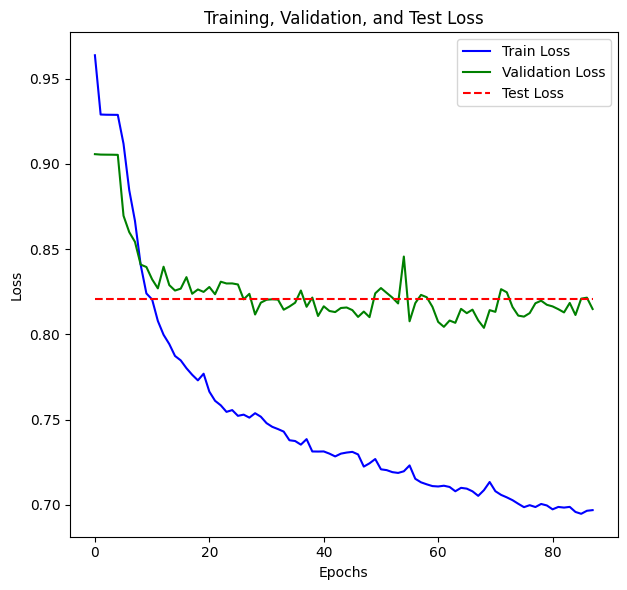

In [ ]:
# Plot: Loss Plot

test_loss_ = [test_loss] * len(train_loss)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label="Train Loss", color='b')
plt.plot(range(len(train_loss)), validation_loss, label="Validation Loss", color='g')
plt.plot(range(len(train_loss)), test_loss_, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

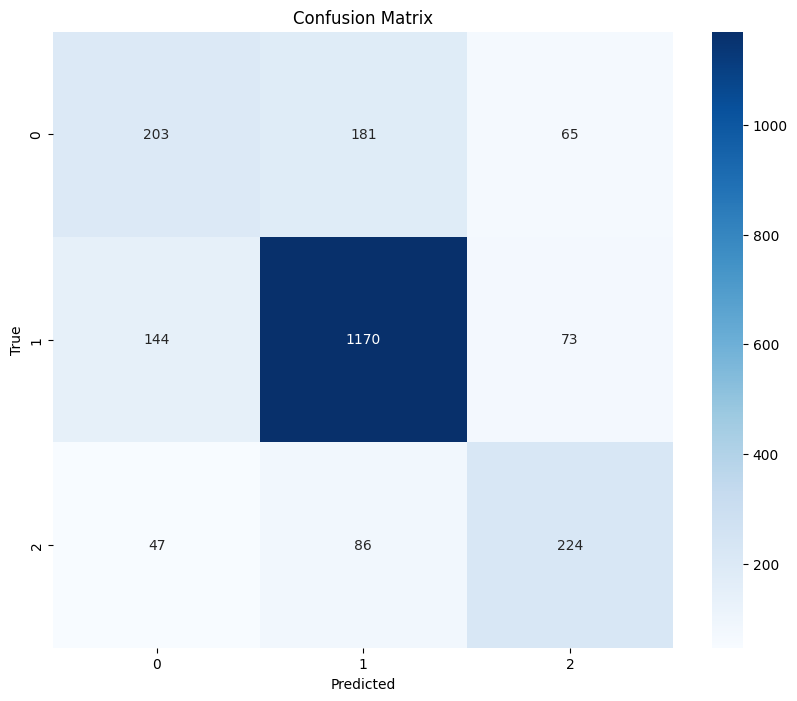

In [ ]:
# Plot : Confusion matrix

cm = confusion_matrix(actual_values, predicted_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the above confusion matrix, class 1 is best predicted with 1170 correct predictions. Also it is highest among all because most of the data belonged to class 1 (i.e. Negative Sentimnent). 

For the class 2 (Positive sentiment), there were 224 correct predictions and 133 incorrect predictions. 

For the class 0 (Neutral sentiment), there were 203 correct predictions and 246 incorrect predictions. Also, most of the tweets were incorrectly classified as Negative (181 in number).

The misclassification rate is significantly higher for class 0 and 2 because of less training data for these classes. The dataset was higly imbalanced. This proves that this base model is good at predicting Negative sentiments and struggles a bit for other sentiments.

In [558]:
for item in Y.unique():
    print(item, (Y == item).sum(), ((Y == item).sum()/Y.shape[0])*100, "%")

neutral 3087 21.117799972636476 %
positive 2359 16.137638527842384 %
negative 9172 62.74456149952113 %


In [559]:
for item in y_train.unique():
    print(item, (y_train == item).sum(), ((y_train == item).sum()/y_train.shape[0])*100, "%")

neutral 2192 21.42298670836591 %
negative 6370 62.2556684910086 %
positive 1670 16.32134480062549 %


In [560]:
for item in y_test.unique():
    print(item, (y_test == item).sum(), ((y_test == item).sum()/y_test.shape[0])*100, "%")

positive 357 16.27906976744186 %
neutral 449 20.47423620611035 %
negative 1387 63.24669402644779 %


4. Save the weights of the trained neural network

In [561]:
### ADD YOUR CODE HERE ###
model_path = "a1_part4_ha33_siyer8.pth"
torch.save(base_model.state_dict(), model_path)

## Step 3: Improved LSTM Model

1. Improve your baseline LSTM model

- ### Bidirectrional LSTM

In [533]:
class SentimentAnalysisImproved(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(SentimentAnalysisImproved, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm3 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [562]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.5
batch_size = 32

improvedModel1 = SentimentAnalysisImproved(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

In [563]:
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel1.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel1, train_loader, val_loader, loss_fn, optimizer, device)

Epoch [1/100], Loss: 0.956, Accuracy: 61.85%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.922, Accuracy: 62.40%
Epoch [3/100], Validation Loss: 0.880, Validation Accuracy: 65.85%
Epoch [4/100], Loss: 0.894, Accuracy: 64.00%
Epoch [4/100], Validation Loss: 0.854, Validation Accuracy: 67.90%
Epoch [5/100], Loss: 0.871, Accuracy: 66.83%
Epoch [5/100], Validation Loss: 0.843, Validation Accuracy: 70.00%
Epoch [6/100], Loss: 0.850, Accuracy: 69.35%
Epoch [6/100], Validation Loss: 0.834, Validation Accuracy: 71.14%
Epoch [7/100], Loss: 0.837, Accuracy: 70.84%
Epoch [7/100], Validation Loss: 0.830, Validation Accuracy: 71.68%
Epoch [8/100], Loss: 0.824, Accuracy: 72.48%
Epoch [8/100], Validation Loss: 0.821, Validation Accuracy: 72.69%
Epoch [9/100], Loss: 0.813, Accuracy: 73.74%
Epoch [9/100], Validation Loss: 0.823, Validation Accuracy:

In [564]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel1, loss_fn)

Test Accuracy: 0.7186502507979936, Precision: 0.7241648657551272, Recall: 0.7186502507979936, F1 Score: 0.7166877422958743
Test loss is 0.8275976267413817


Result: Test accuracy is slightly decreased, and the training accuracy also decreased. But the validation accuracy is slightly increased, which suggests that the model is less overfitting on the training data.

- ### Stacked LSTM

Adding one more LSTM Layer with bidirection=False

In [570]:
class StackedLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(StackedLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)

        x, _ = self.lstm4(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [571]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.5
batch_size = 32

improvedModel2 = StackedLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

In [572]:
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel2.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel2, train_loader, val_loader, loss_fn, optimizer, device)

Epoch [1/100], Loss: 0.963, Accuracy: 59.50%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

In [573]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel2, loss_fn)

Test Accuracy: 0.6324669402644779, Precision: 0.4000144305275106, Recall: 0.6324669402644779, F1 Score: 0.4900735453334251
Test loss is 0.919278313284335


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Result: Not a good approach as the accuracy is decreased.

- ### Stacked LSTM Bidirectional

In [576]:
class StackedLSTMBi(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(StackedLSTMBi, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm3 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm4 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)

        x, _ = self.lstm4(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [577]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.5
batch_size = 32

improvedModel3 = StackedLSTMBi(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel3.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel3, train_loader, val_loader, loss_fn, optimizer, device)
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel3, loss_fn)

Epoch [1/100], Loss: 0.952, Accuracy: 62.20%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.928, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.910, Accuracy: 63.07%
Epoch [6/100], Validation Loss: 0.872, Validation Accuracy: 66.21%
Epoch [7/100], Loss: 0.875, Accuracy: 66.15%
Epoch [7/100], Validation Loss: 0.851, Validation Accuracy: 68.99%
Epoch [8/100], Loss: 0.848, Accuracy: 69.78%
Epoch [8/100], Validation Loss: 0.843, Validation Accuracy: 70.04%
Epoch [9/100], Loss: 0.830, Accuracy: 71.75%
Epoch [9/100], Validation Loss: 0.840, Validation Accuracy:

Result: Overall better than without using bidirectional.

**What if I increase the dropout rate?**

- dropout = 0.6

In [ ]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3 
dropout = 0.6 # Dropout increased to 0.6
batch_size = 32

improvedModel3 = StackedLSTMBi(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel3.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel3, train_loader, val_loader, loss_fn, optimizer, device)
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel3, loss_fn)

Epoch [1/100], Loss: 0.956, Accuracy: 61.99%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.906, Accuracy: 63.04%
Epoch [7/100], Validation Loss: 0.875, Validation Accuracy: 66.53%
Epoch [8/100], Loss: 0.888, Accuracy: 64.41%
Epoch [8/100], Validation Loss: 0.863, Validation Accuracy: 66.62%
Epoch [9/100], Loss: 0.865, Accuracy: 67.48%
Epoch [9/100], Validation Loss: 0.842, Validation Accuracy:

Result: Increased test accuracy!

- dropout = 0.65

In [579]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3 
dropout = 0.65
batch_size = 32

improvedModel3 = StackedLSTMBi(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel3.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel3, train_loader, val_loader, loss_fn, optimizer, device)
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel3, loss_fn)

Epoch [1/100], Loss: 0.957, Accuracy: 62.02%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

Result: There is slight decrease in test accuracy.

- ### Implementing GRU

Case 1: bidirectional = False

In [581]:
class ModelGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModelGRU, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm2 = nn.GRU(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.lstm3 = nn.GRU(hidden_dim, hidden_dim, bidirectional=False, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [582]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.5
batch_size = 32

improvedModel4 = ModelGRU(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel4.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel4, train_loader, val_loader, loss_fn, optimizer, device)


Epoch [1/100], Loss: 0.956, Accuracy: 61.48%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

In [583]:
test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel4, loss_fn)

Test Accuracy: 0.7250341997264022, Precision: 0.7147028698617539, Recall: 0.7250341997264022, F1 Score: 0.7184880306545512
Test loss is 0.82355053614879


Case 2: bidirectional=True and dropout = 0.6

In [584]:
class ModelGRU2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModelGRU2, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm3 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [589]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.6
batch_size = 32

improvedModel5 = ModelGRU2(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel5.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel5, train_loader, val_loader, loss_fn, optimizer, device)

test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel5, loss_fn)

Epoch [1/100], Loss: 0.950, Accuracy: 61.83%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

Case 3: Using dropout = 0.65

In [ ]:
class ModelGRU3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModelGRU3, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm3 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [596]:
# Model parameters
vocab_size = len(training_vocab)+1  # Adjust based on your vocabulary size
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Positive, Negative, Neutral
dropout = 0.65
batch_size = 32

improvedModel6 = ModelGRU3(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)

num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improvedModel6.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, improvedModel6, train_loader, val_loader, loss_fn, optimizer, device)

test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, improvedModel6, loss_fn)


Epoch [1/100], Loss: 0.956, Accuracy: 61.12%
Epoch [1/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.929, Accuracy: 62.26%
Epoch [2/100], Validation Loss: 0.906, Validation Accuracy: 64.52%
Epoch [3/100], Loss: 0.929, Accuracy: 62.26%
Epoch [3/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [4/100], Loss: 0.929, Accuracy: 62.26%
Epoch [4/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [5/100], Loss: 0.929, Accuracy: 62.26%
Epoch [5/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [6/100], Loss: 0.929, Accuracy: 62.26%
Epoch [6/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [7/100], Loss: 0.929, Accuracy: 62.26%
Epoch [7/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [8/100], Loss: 0.929, Accuracy: 62.26%
Epoch [8/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [9/100], Loss: 0.929, Accuracy: 62.26%
Epoch [9/100], Validation Loss: 0.905, Validation Accuracy:

Result: Training accuracy is decreased but testing accuracy is slightly increased !

- ### Using Pre-trained Word Embeddings : FastText

In [ ]:
# !pip install fasttext

In [1]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
# Prepare embedding layer form the training vocabulary

word_vectors = ft.get_word_vector  # fetches the embedding for a given word

vocab_size = len(training_vocab)+1
embedding_dim = 300  # FastText embeddings are 300-dimensional

# Initialize an empty embedding matrix
embedding_matrix = torch.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with FastText embeddings
for word, idx in training_vocab.items():
    embedding_matrix[idx] = torch.tensor(ft.get_word_vector(word))

# freeze the embeddings, to not be updated during training
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

In [ ]:
class ModelGRUwithEmb(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout, emb_layer):
        super(ModelGRUwithEmb, self).__init__()
        
        self.embedding = emb_layer # Use the pre-trained FastText embeddings
        
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru2 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru3 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.gru1(x)
        x = self.dropout(x)
        
        x, _ = self.gru2(x)
        x = self.dropout(x)
        
        x, _ = self.gru3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

In [47]:
# Model parameters
embedding_dim = 300
num_epochs = 100
hidden_dim = 128
output_dim = 3
dropout = 0.65

# Initialize model with pre-trained FastText embeddings
modelWithEmb = ModelGRUwithEmb(vocab_size, embedding_dim, hidden_dim, output_dim, dropout, embedding_layer)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelWithEmb.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, modelWithEmb, train_loader, val_loader, loss_fn, optimizer, device)

test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, modelWithEmb, loss_fn)


Epoch [1/100], Loss: 0.951, Accuracy: 61.23%
Epoch [1/100], Validation Loss: 0.905, Validation Accuracy: 64.52%
Epoch [2/100], Loss: 0.880, Accuracy: 65.53%
Epoch [2/100], Validation Loss: 0.814, Validation Accuracy: 73.42%
Epoch [3/100], Loss: 0.786, Accuracy: 76.22%
Epoch [3/100], Validation Loss: 0.792, Validation Accuracy: 75.33%
Epoch [4/100], Loss: 0.735, Accuracy: 81.57%
Epoch [4/100], Validation Loss: 0.780, Validation Accuracy: 76.38%
Epoch [5/100], Loss: 0.708, Accuracy: 84.32%
Epoch [5/100], Validation Loss: 0.783, Validation Accuracy: 76.61%
No improvement for 1 epochs.
Epoch [6/100], Loss: 0.688, Accuracy: 86.21%
Epoch [6/100], Validation Loss: 0.774, Validation Accuracy: 77.47%
Epoch [7/100], Loss: 0.679, Accuracy: 87.24%
Epoch [7/100], Validation Loss: 0.777, Validation Accuracy: 77.43%
No improvement for 1 epochs.
Epoch [8/100], Loss: 0.673, Accuracy: 87.81%
Epoch [8/100], Validation Loss: 0.777, Validation Accuracy: 77.15%
No improvement for 2 epochs.
Epoch [9/100], Lo

Result: After using pre-trained embedding, the acuracy is increased and test accuracy is above 75%!

2. Create a new class for your improved model

In [48]:
class ImprovedModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout, emb_layer):
        super(ImprovedModel, self).__init__()
        
        self.embedding = emb_layer
        
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru2 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru3 = nn.GRU(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.gru1(x)
        x = self.dropout(x)
        
        x, _ = self.gru2(x)
        x = self.dropout(x)
        
        x, _ = self.gru3(x)
        x = self.dropout(x)
        
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        
        return x
    
    

3. Follow the same training and evaluation procedures

In [50]:
embedding_dim = 300
num_epochs = 100
hidden_dim = 128
output_dim = 3
dropout = 0.65

model_improved = ImprovedModel(embedding_dim, hidden_dim, output_dim, dropout, embedding_layer)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.0001)

train_loss, validation_loss = train_model(num_epochs, model_improved, train_loader, val_loader, loss_fn, optimizer, device)

test_loss , test_accuracy = 0,0
actual_values = []
predicted_val = []
test_loss, test_accuracy, actual_values, predicted_val = test_loop(test_loader, model_improved, loss_fn)


Epoch [1/100], Loss: 0.915, Accuracy: 64.01%
Epoch [1/100], Validation Loss: 0.824, Validation Accuracy: 70.36%
Epoch [2/100], Loss: 0.707, Accuracy: 85.42%
Epoch [2/100], Validation Loss: 0.791, Validation Accuracy: 75.83%
Epoch [3/100], Loss: 0.653, Accuracy: 90.07%
Epoch [3/100], Validation Loss: 0.792, Validation Accuracy: 75.51%
No improvement for 1 epochs.
Epoch [4/100], Loss: 0.645, Accuracy: 90.71%
Epoch [4/100], Validation Loss: 0.785, Validation Accuracy: 76.33%
Epoch [5/100], Loss: 0.643, Accuracy: 90.87%
Epoch [5/100], Validation Loss: 0.786, Validation Accuracy: 76.24%
No improvement for 1 epochs.
Epoch [6/100], Loss: 0.641, Accuracy: 91.13%
Epoch [6/100], Validation Loss: 0.791, Validation Accuracy: 75.79%
No improvement for 2 epochs.
Epoch [7/100], Loss: 0.639, Accuracy: 91.32%
Epoch [7/100], Validation Loss: 0.793, Validation Accuracy: 75.56%
No improvement for 3 epochs.
Epoch [8/100], Loss: 0.639, Accuracy: 91.32%
Epoch [8/100], Validation Loss: 0.799, Validation Accur

In [51]:
summary(model_improved, input_size=(batch_size, perc95), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedModel                            [32, 3]                   --
├─Embedding: 1-1                         [32, 15, 300]             3,075,000
├─GRU: 1-2                               [32, 15, 256]             330,240
├─Dropout: 1-3                           [32, 15, 256]             --
├─GRU: 1-4                               [32, 15, 256]             296,448
├─Dropout: 1-5                           [32, 15, 256]             --
├─GRU: 1-6                               [32, 15, 256]             296,448
├─Dropout: 1-7                           [32, 15, 256]             --
├─Linear: 1-8                            [32, 3]                   771
├─Softmax: 1-9                           [32, 3]                   --
Total params: 3,998,907
Trainable params: 3,998,907
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 541.53
Input size (MB): 0.00
Forward/backward pass size (MB): 4.10
Params size (MB): 16.00


4. Directly compare the performance of your improved model to the baseline model

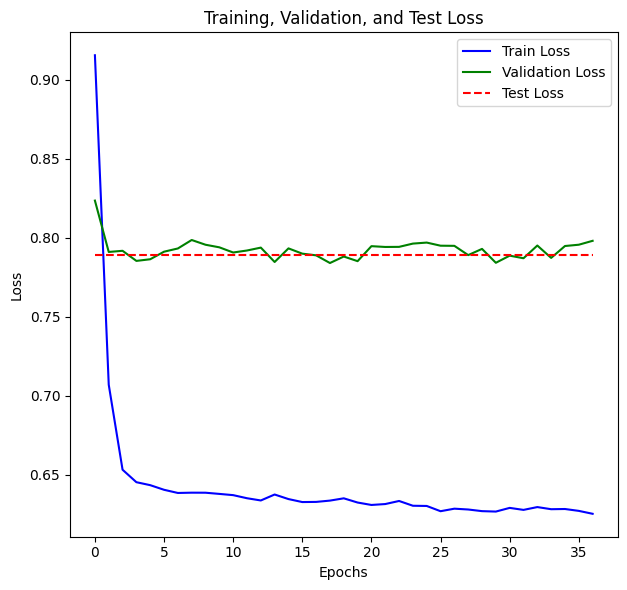

In [52]:
test_loss_ = [test_loss] * len(train_loss)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label="Train Loss", color='b')
plt.plot(range(len(train_loss)), validation_loss, label="Validation Loss", color='g')
plt.plot(range(len(train_loss)), test_loss_, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

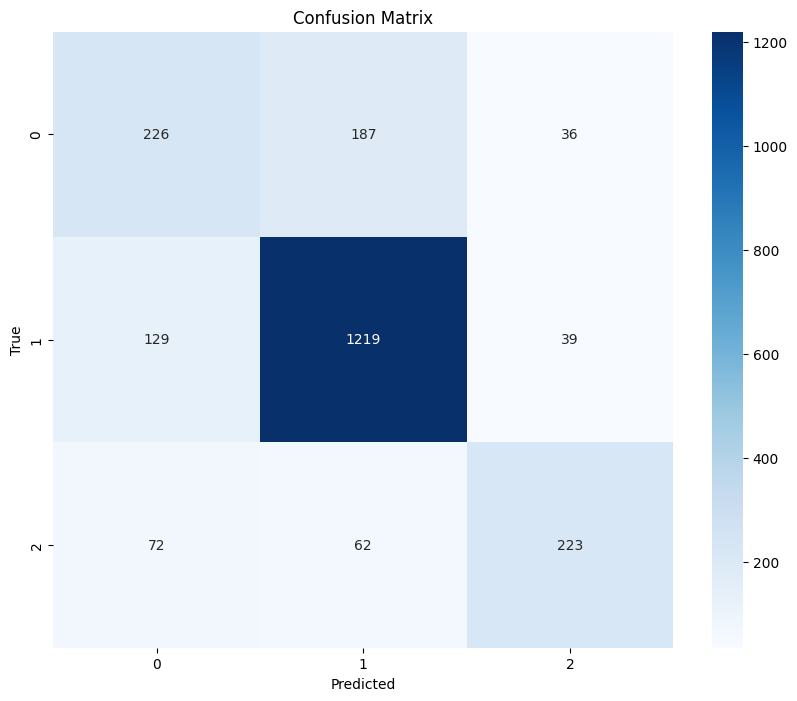

In [53]:
# Plot Confusion matrix
cm = confusion_matrix(actual_values, predicted_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Improved Best Model Characteristics:

- Training accuracy : 90.88%
- Validation accuracy : 75.7%
- **Test Accuracy: 76.06%**
- Precision: 0.7553735228599601, Recall: 0.7606019151846786, F1 Score: 0.7565792218632877
- Test loss : 0.789274956005207

### Observations:

- There has been significant increase in the test accuracy, from 72.8% in base model to 76% in the improved model.
- Training accuracy is high, which suggest that the model is likely overfitting on the training data.
- Training time is only 90 sec in the improved model, as compared to 266 sec in the base model (likely due to early stopping).
- Training and Validation loss plot is more smooth in the case of improved model as compared to the base model.
- There has been increase in the number of true positives in the Confusion Matrix for the Class 0 and 1.

5. Save the weights of the trained neural network

In [55]:
model_path = "a1_part4_improved_ha33_siyer8.pth"
torch.save(model_improved.state_dict(), model_path)

## Step 4: Discussion

1. Briefly describe the dataset and its key characteristics

Link: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

This dataset is of top US Airline reviews from Twitter. This dataset was scraped from February 2015 and classified into 3 sentiments: Positive, Negative, and Neutral tweets. It has a total of 15 columns and 14640 rows. The class distribution is as follows: 

|Sentiments | Count | Percentage |
| ---------- | ------ | --------- |
|neutral |	 3099 	| 21.17%|
|positive |	 2363 	| 16.14%|
|negative |	 9178 	| 62.69%|

2. Describe both your baseline and improved LSTM architectures in detail

#### **Baseline model**

Hyperparameters:

- Embedding Dimention = 100 
- Hidden Dimention = 128
- Dropout = 0.5
- Batch Size = 32
- Number of Epochs = 100 (early stopping at 88th epoch)
- Loss Function = Cross Entropy Loss
- Optimizer = Adam with lr=0.0001
- Layers: One NN Embedding layer and 3 LSTM layers with dropouts in between LSTM layers 
- Total params: 1,407,339

Results:

- Training Accuracy = 80.07%
- Validation Accuracy = 72.15%
- Test Accuracy = 72.82%
- Precision: 0.72, Recall: 0.72, F1 Score: 0.72
- Average test loss = 0.82

#### **Improved Model**

Hyperparameters:

- Embedding Dimention = 300 (Using pre-trained Embeddings FastText)
- Hidden Dimention = 128
- Dropout = 0.65
- Batch Size = 32
- Number of Epochs = 100 (early stopping at 37th epoch)
- Loss Function = Cross Entropy Loss
- Optimizer = Adam with lr=0.0001
- Layers: One Pre-trained Embedding layer and 3 Bidirectional GRU layers with dropouts
- Total params: 3,998,907

Results:

- Training Accuracy = 90.88%
- Validation Accuracy = 75.7%
- Test Accuracy = **76.06%**
- Precision: 0.75, Recall: 0.76, F1 Score: 0.75
- Average test loss = 0.82


3. Discuss the results, comparing the performance of the baseline and improved models

There has been a significant increase in test accuracy from 72.8% to 76.06% in the improved model. Using Bidirectional LSTM and Stacked LSTM (with a dropout rate of 0.5) did not show much improvement in accuracy. However, implementing Bidirectional GRU layers with a high dropout rate of 0.65 yielded much better results, reducing overfitting on the training data.

The test accuracy further increased by using pre-trained FastText embedding layers, but overfitting was observed on the training data.

Additionally, training was much smoother (as seen from the loss plot) and faster, as the loss function reached its local minimum in fewer epochs. This suggests that the model was able to learn more effectively using pre-trained word embeddings.

4. Discuss the strengths and limitations of using recurrent neural models for sentiment analysis

Recurrent Neural Networks (RNNs) can be used for Sentiment Analysis as they can capture information from previous network layers. But there is a issue of Vanishing Gradients and the computational cost is high.

LSTMs and GRUs solves the issue of Vanishing Gradients (upto a certain extent) by introducing various gates to capture long term memory. They are much better at sentiment analysis tasks, but there is always an issue of overfitting on the training data, as seen above. 

5. References. Include details on all the resources used to complete this part.

REFERENCES

https://www.geeksforgeeks.org/python-remove-punctuation-from-string/

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

https://spacy.io/usage

https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

https://pytorch.org/docs/stable/tensors.html

https://www.geeksforgeeks.org/pre-trained-word-embedding-in-nlp/

https://www.tensorflow.org/text/tutorials/word2vec

https://fasttext.cc/docs/en/english-vectors.html

https://fasttext.cc/docs/en/crawl-vectors.html

https://hussainwali.medium.com/using-fasttext-embeddings-in-pytorch-boosting-neural-network-performance-fe017c39c7c3

